## Import modules

In [1]:
import math
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import typing as t

## Utils

In [2]:
T = t.TypeVar('T')
Tuple2 = t.Tuple[T, T]
ComputeProbaFn = t.Callable[[float, float, ...], float]

In [3]:
def plot_hist(data: t.Iterable,
              title: t.Optional[str] = None,
              figsize: Tuple2[float] = (8, 6),
              fontsize: int = 14,
              ax: t.Optional[plt.Axes] = None,
              **kwargs: t.Any) -> plt.Axes:
    if ax is None:
        ax = plt.subplots(figsize=figsize)[1]
    # sns.histplot(data, color='blue', edgecolor='white', ax=ax, **kwargs)
    ax.hist(data, color='blue', edgecolor='white', **kwargs)
    ax.grid(True)
    ax.set_xlabel('Value', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    return ax


def compute_stats(data: np.ndarray) -> Tuple2[float]:
    return np.mean(data), np.std(data, ddof=1)


def get_bins(bin_edges: np.ndarray) -> t.List[Tuple2[float]]:
    return [(bin_edges[idx - 1], bin_edges[idx]) for idx in range(1, bin_edges.size)]


def compute_chi2(alpha: float, num_bins: int, num_dist_params: int) -> float:
    return stats.chi2.ppf(1 - alpha, num_bins - num_dist_params - 1)


def compute_chi2_hat(counts: np.ndarray, bin_edges: np.ndarray, num_samples: int, compute_proba: ComputeProbaFn,
                     *args: t.Any, **kwargs: t.Any) -> float:
    probs_hat = np.array([compute_proba(lhs, rhs, *args, **kwargs) for lhs, rhs in get_bins(bin_edges)])
    counts_hat = probs_hat * num_samples
    return np.sum(np.square(counts - counts_hat) / counts_hat)


def accept_chi2(chi2_hat: float, chi2: float) -> bool:
    return chi2_hat <= chi2

## Exponential distribution

In [4]:
def compute_exp_proba(lhs: float, rhs: float, lambda_: float) -> float:
    return math.exp(-lhs * lambda_) - math.exp(-rhs * lambda_)

### Config

In [5]:
exp_num_samples = 10000
lambda_ = 3
exp_num_bins = 20
exp_alpha = 0.05

### Generation

In [6]:
xi_exp = np.random.uniform(size=exp_num_samples)
x_exp = -1 / lambda_ * np.log(xi_exp)

### Histogram

In [7]:
exp_counts, exp_bin_edges = np.histogram(x_exp, bins=exp_num_bins)

<AxesSubplot:title={'center':'Exponential distribution'}, xlabel='Value', ylabel='Count'>

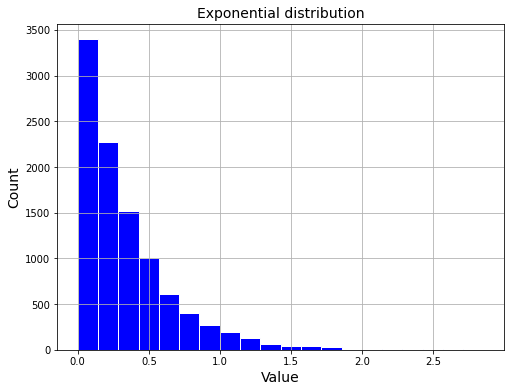

In [8]:
plot_hist(x_exp, bins=exp_bin_edges, title='Exponential distribution')

### Test

In [9]:
exp_mean, exp_std = compute_stats(x_exp)
mean_lambda = 1 / exp_mean
std_lambda = 1 / exp_std
lambda_hat = (mean_lambda + std_lambda) / 2

In [10]:
print(f'Mean: {exp_mean:.3f}. Std: {exp_std:.3f}')
print(f'Lambda: {lambda_hat:.3f}')

Mean: 0.339. Std: 0.339
Lambda: 2.953


In [12]:
exp_chi2_hat = compute_chi2_hat(counts=exp_counts,
                                bin_edges=exp_bin_edges,
                                num_samples=exp_num_samples,
                                compute_proba=compute_exp_proba,
                                lambda_=lambda_hat)
exp_num_dist_params = 1
exp_chi2 = compute_chi2(alpha=exp_alpha, num_bins=exp_num_bins, num_dist_params=exp_num_dist_params)

In [13]:
print(f'Estimated Chi2: {exp_chi2_hat:.3f}. Chi2 critical value: {exp_chi2:.3f}')
print('Accepted!' if accept_chi2(exp_chi2_hat, exp_chi2) else 'Rejected!')

Estimated Chi2: 19.279. Chi2 critical value: 28.869
Accepted!


## Normal distribution

In [14]:
def compute_norm_proba(lhs: float, rhs: float, mean: float, std: float) -> float:
    lhs_cdf, rhs_cdf = stats.norm.cdf([lhs, rhs], loc=mean, scale=std)
    return rhs_cdf - lhs_cdf

### Config

In [15]:
norm_num_samples = 10000
sigma = 2
mean = -3
norm_num_bins = 20
norm_alpha = 0.05

### Generation

In [16]:
xi_norm = np.random.uniform(size=(norm_num_samples, 12))
mu_norm = xi_norm.sum(axis=1) - 6
x_norm = sigma * mu_norm + mean

### Histogram

In [17]:
norm_counts, norm_bin_edges = np.histogram(x_norm, bins=norm_num_bins)

<AxesSubplot:title={'center':'Normal distribution'}, xlabel='Value', ylabel='Count'>

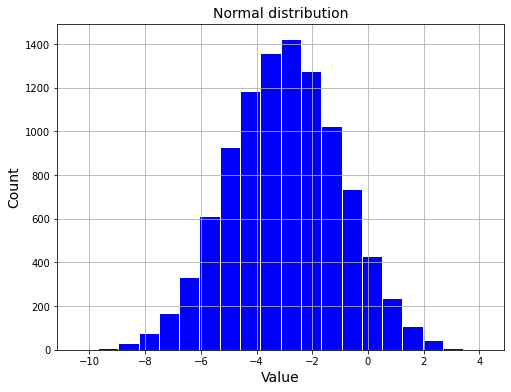

In [18]:
plot_hist(x_norm, bins=norm_bin_edges, title='Normal distribution')

### Test

In [19]:
norm_mean_hat, norm_std_hat = compute_stats(x_norm)

In [20]:
print(f'Mean: {norm_mean_hat:.3f}. Std: {norm_std_hat:.3f}')

Mean: -2.989. Std: 2.006


In [21]:
norm_chi2_hat = compute_chi2_hat(counts=norm_counts,
                                 bin_edges=norm_bin_edges,
                                 num_samples=norm_num_samples,
                                 compute_proba=compute_norm_proba,
                                 mean=norm_mean_hat,
                                 std=norm_std_hat)
norm_num_dist_params = 2
norm_chi2 = compute_chi2(alpha=norm_alpha, num_bins=norm_num_bins, num_dist_params=norm_num_dist_params)

In [22]:
print(f'Estimated Chi2: {norm_chi2_hat:.3f}. Chi2 critical value: {norm_chi2:.3f}')
print('Accepted!' if accept_chi2(norm_chi2_hat, norm_chi2) else 'Rejected!')

Estimated Chi2: 8.626. Chi2 critical value: 27.587
Accepted!


## Uniform distribution

In [24]:
def compute_uniform_proba(lhs: float, rhs: float, a: float, b: float) -> float:
    return (rhs - lhs) / (b - a)

### Config

In [25]:
uniform_num_samples = 10000
a = 5**13
c = 2**31
uniform_num_bins = 20
uniform_alpha = 0.05

### Generation

In [26]:
x_uniform = np.empty(uniform_num_samples)
z_uniform = random.randint(0, c)

for idx in range(uniform_num_samples):
    z_uniform = (a * z_uniform) % c
    x_uniform[idx] = z_uniform / c

### Histogram

In [27]:
uniform_counts, uniform_bin_edges = np.histogram(x_uniform, bins=uniform_num_bins)

<AxesSubplot:title={'center':'Uniform distribution'}, xlabel='Value', ylabel='Count'>

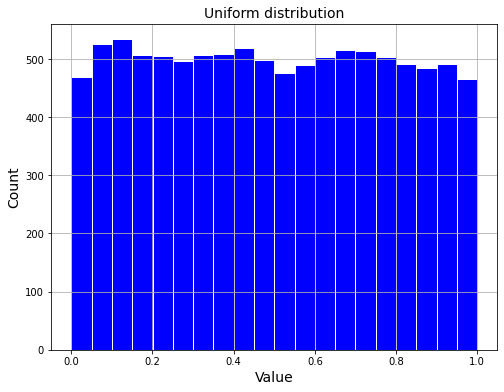

In [28]:
plot_hist(x_uniform, bins=uniform_bin_edges, title='Uniform distribution')

### Test

In [29]:
uniform_mean, uniform_std = compute_stats(x_uniform)
uniform_a = uniform_mean - math.sqrt(3) * uniform_std
uniform_b = uniform_mean + math.sqrt(3) * uniform_std

In [30]:
print(f'A: {uniform_a}. B: {uniform_b}')
print(f'Mean: {uniform_mean:.3f}. Std: {uniform_std:.3f}')

A: -0.0010328207397883316. B: 0.9943993062460845
Mean: 0.497. Std: 0.287


In [31]:
uniform_chi2_hat = compute_chi2_hat(counts=uniform_counts,
                                    bin_edges=uniform_bin_edges,
                                    num_samples=uniform_num_samples,
                                    compute_proba=compute_uniform_proba,
                                    a=uniform_a,
                                    b=uniform_b)
uniform_num_dist_params = 2
uniform_chi2 = compute_chi2(alpha=uniform_alpha, num_bins=uniform_num_bins, num_dist_params=uniform_num_dist_params)

In [32]:
print(f'Estimated Chi2: {uniform_chi2_hat:.3f}. Chi2 critical value: {uniform_chi2:.3f}')
print('Accepted!' if accept_chi2(uniform_chi2_hat, uniform_chi2) else 'Rejected!')

Estimated Chi2: 12.179. Chi2 critical value: 27.587
Accepted!
